# 2 Perceptron vs Neural Networks
Student ID: 35224436 | Full name: Yiming Zhang

## Question 2 Neural Network’s Decision Boundary

### Task I

#### Load Data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


# paths
train_path = '/Users/2m/Documents/Monash/FIT5201/Assignment/ML_ASS/ASS2/Dataset_S2_2025/Task2B_train.csv'
test_path = '/Users/2m/Documents/Monash/FIT5201/Assignment/ML_ASS/ASS2/Dataset_S2_2025/Task2B_test.csv'

# load
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# columns
feat_cols = [c for c in train.columns if c.lower().startswith('feature')]
label_col = 'label' if 'label' in train.columns else train.columns[-1]

# map labels from {0,1} to {-1,+1}
_mapping = {0: -1, 1: 1}
if set(train[label_col].unique()) <= set(_mapping.keys()):
    train[label_col] = train[label_col].map(_mapping).astype(int)
if set(test[label_col].unique()) <= set(_mapping.keys()):
    test[label_col] = test[label_col].map(_mapping).astype(int)

labels_all = sorted(set(train[label_col]) | set(test[label_col]))

# print info
print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Columns:', list(train.columns))
print('Label values (train):', sorted(train[label_col].unique()))
print('Label values (test):', sorted(test[label_col].unique()))



Train shape: (500, 3)
Test shape: (2000, 3)
Columns: ['feature1', 'feature2', 'label']
Label values (train): [-1, 1]
Label values (test): [-1, 1]


#### Plot Function

In [22]:
def plot_train_test_scatter(train_df, test_df, feat_cols, label_col, labels_all=None):
    labels_all = sorted(set(train_df[label_col]) | set(test_df[label_col])) if labels_all is None else labels_all
    cmap = plt.get_cmap('Set3', len(labels_all))
    label_to_idx = {lab: i for i, lab in enumerate(labels_all)}

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

    # helper: single panel
    def _panel(ax, df, title):
        for lab in labels_all:
            m = df[label_col] == lab
            ax.scatter(df.loc[m, feat_cols[0]], df.loc[m, feat_cols[1]],
                       color=cmap(label_to_idx[lab]), label=f'Label {lab}',
                       alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
        # (0, 0)
        ax.scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
        ax.set_title(title)
        ax.set_xlabel(feat_cols[0])
        ax.set_ylabel(feat_cols[1])
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
        ax.legend(title=None)

    _panel(axs[0], train_df, 'Training data')
    _panel(axs[1], test_df, 'Testing data')
    plt.show()



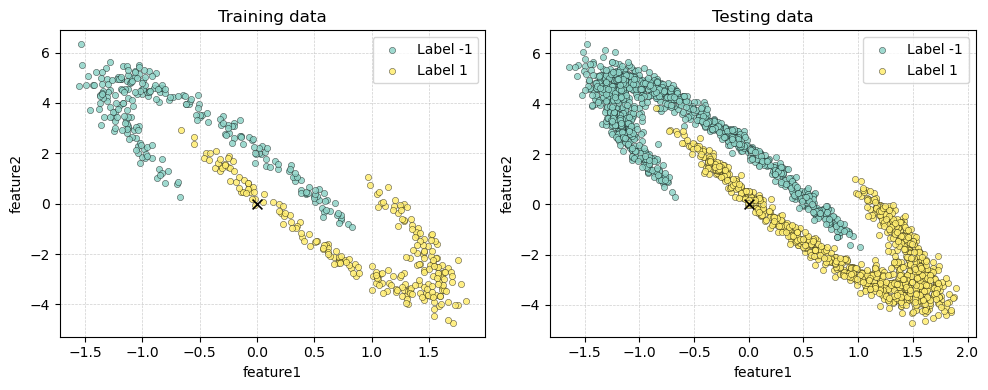

In [23]:
plot_train_test_scatter(train, test, feat_cols, label_col)

### Task II
Train two Perceptron models on the provided training data: one with early stopping and
one without.

#### Perceptron Implementation

In [42]:
class Perceptron:

    def __init__(
        self,
        eta=0.01,
        tau_max=10000,
        epsilon=0.001,
        early_stopping=False,
        threshold=0.001,
        lam=0.0,
        random_state=None,
    ):
        self.eta = eta  # learning rate
        self.tau_max = tau_max  # max number of iterations/epochs
        self.epsilon = epsilon  # tolerable training error (no ES)
        self.early_stopping = early_stopping
        self.threshold = threshold  # ES: stop if val error change < threshold
        self.lam = lam  # L2 (weight decay)
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape

        self.w_trace_ = np.empty((self.tau_max, p))  # trace of weights during training
        self.xy_idx_trace_ = np.empty(
            self.tau_max, int
        )  # trace of considered training point indices

        # initialisation of iteration counter and weights
        tau = 0
        self.w_ = self.w_trace_[0, :] = RNG.normal(size=p)

        # prepare train/val split for early stopping (20%)
        if self.early_stopping:
            idx = RNG.permutation(n)
            val_size = max(1, int(0.2 * n))
            val_idx = idx[:val_size]
            tr_idx = idx[val_size:]
            X_tr, y_tr = x[tr_idx], y[tr_idx]
            X_val, y_val = x[val_idx], y[val_idx]
        else:
            X_tr, y_tr = x, y
            X_val = y_val = None

        last_val_err = None
        terminate = False
        while not terminate:
            # random order to consider training data
            m = X_tr.shape[0]
            order = RNG.choice(np.arange(m), size=m, replace=False)
            for i in range(m):
                # L2 regularization (weight decay)
                if self.lam > 0:
                    self.w_ = self.w_ * (1 - self.eta * self.lam)

                # prediction with labels in {-1, +1}
                xi = X_tr[order][i]
                yi = y_tr[order][i]
                pred = 1 if xi.dot(self.w_) >= 0 else -1
                if pred != yi:  # perceptron update
                    self.w_ = self.w_ + self.eta * yi * xi

                # traces
                if tau + 1 < self.w_trace_.shape[0]:
                    self.w_trace_[tau + 1] = self.w_
                self.xy_idx_trace_[tau] = order[i]
                tau += 1
                if tau >= self.tau_max - 1:
                    terminate = True
                    break

            # check stopping
            if self.early_stopping and X_val is not None:
                val_pred = np.where(X_val.dot(self.w_) >= 0, 1, -1)
                val_err = (val_pred != y_val).mean()
                if last_val_err is not None and abs(last_val_err - val_err) < self.threshold:
                    terminate = True
                last_val_err = val_err
            else:
                tr_pred = np.where(X_tr.dot(self.w_) >= 0, 1, -1)
                tr_err = (tr_pred != y_tr).mean()
                if tr_err < self.epsilon:
                    terminate = True

        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau]
        self.xy_idx_trace_ = self.xy_idx_trace_[: max(0, tau - 1)]

        return self

    def predict(self, x):
        # return labels in {-1, +1}
        return np.where(x.dot(self.w_) >= 0, 1, -1)

#### Parameters Fine-tuning & Validation

In [ ]:
# prepare data
X = train[feat_cols].values
Y = train[label_col].values
X_test = test[feat_cols].values
Y_test = test[label_col].values

# coercion to {-1,+1}
def to_pm1(a):
    a = np.asarray(a)
    u = set(np.unique(a))
    if u.issubset({0, 1}):
        return np.where(a == 1, 1, -1)
    return a.astype(int)

# error on test
def test_error(model, X, y):
    y_pred = to_pm1(model.predict(X))
    y_true = to_pm1(y)
    return (y_pred != y_true).mean()

etas = [0.001, 0.01, 0.1]
lams = [0.0001, 0.001, 0.01, 0.1, 1.0]

results_no_es = []
results_es = []

for eta in etas:
    for lam in lams:
        # without early stopping (train on full training set)
        m0 = Perceptron(eta=eta, lam=lam, early_stopping=False, random_state=42)
        m0.fit(X, Y)
        err0 = test_error(m0, X_test, Y_test)
        results_no_es.append({'eta': eta, 'lam': lam, 'test_err': err0, 'model': m0})

        # with early stopping (uses internal 20% validation, threshold=0.001)
        m1 = Perceptron(eta=eta, lam=lam, early_stopping=True, random_state=42)
        m1.fit(X, Y)
        err1 = test_error(m1, X_test, Y_test)
        results_es.append({'eta': eta, 'lam': lam, 'test_err': err1, 'model': m1})

# select best
best_no_es = min(results_no_es, key=lambda r: r['test_err'])
best_es = min(results_es, key=lambda r: r['test_err'])

print('No Early stopping best:', {'eta': best_no_es['eta'], 'lam': best_no_es['lam'], 'test_err': best_no_es['test_err']})
print('Early stopping best:', {'eta': best_es['eta'], 'lam': best_es['lam'], 'test_err': best_es['test_err']})

# summary tables
_df_no_es = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_no_es]).sort_values('test_err').reset_index(drop=True)
_df_es = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_es]).sort_values('test_err').reset_index(drop=True)

display(_df_no_es)
display(_df_es)
best_model_no_es = best_no_es['model']
best_model_es = best_es['model']



No Early stopping best: {'eta': 0.001, 'lam': 1.0, 'test_err': 0.1285}
Early stopping best: {'eta': 0.001, 'lam': 0.0001, 'test_err': 0.1285}


,eta,lam,test_err
0,0.001,1.0000,0.1285
1,0.001,0.0010,0.1290
2,0.010,0.0010,0.1290
3,0.010,0.0100,0.1290
4,0.100,0.0100,0.1295
5,0.001,0.0100,0.1330
6,0.001,0.0001,0.1370
7,0.010,1.0000,0.1380
8,0.100,0.1000,0.1380
9,0.010,0.1000,0.1385


,eta,lam,test_err
0,0.001,0.0001,0.1285
1,0.001,0.0010,0.1285
2,0.001,0.0100,0.1285
3,0.001,0.1000,0.1285
4,0.001,1.0000,0.1285
5,0.010,0.0100,0.1285
6,0.010,1.0000,0.1285
7,0.100,1.0000,0.1285
8,0.100,0.0010,0.1310
9,0.010,0.1000,0.1315


#### Plot Function
Plot showing the best models with and without early stopping and their decision boundaries

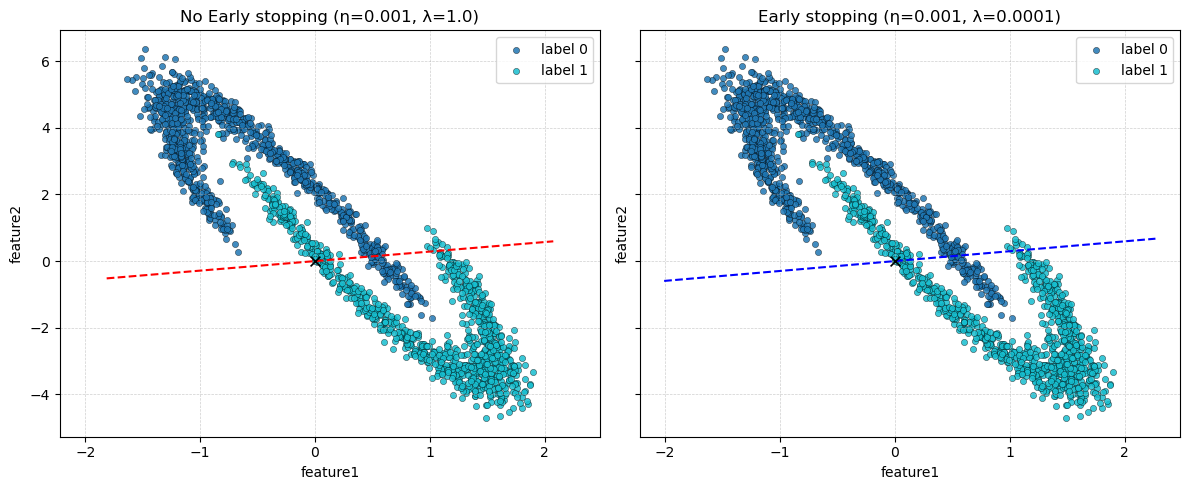

In [ ]:
# liner decision boundary (x2 = -(w1/w2) * x1)
def plot_line_from_w(ax, w, color):
    if abs(w[1]) < 1e-12:
        ax.plot([0, 0], ax.get_ylim(), linestyle='--', color=color, label='_nolegend_')
    else:
        xlim = ax.get_xlim()
        x = np.linspace(xlim[0], xlim[1], 200)
        y = -(w[0] / w[1]) * x
        ax.plot(x, y, linestyle='--', color=color, label='_nolegend_')

labels_all = sorted(test[label_col].unique())  # {-1,+1}
lab_name = { -1: 'label 0', 1: 'label 1' }
cmap = plt.get_cmap('tab10', len(labels_all))
label_to_idx = {lab: i for i, lab in enumerate(labels_all)}

fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True, sharex=True, sharey=True)

# Left: No Early stopping
for lab in labels_all:
    m = test[label_col] == lab
    axs[0].scatter(test.loc[m, feat_cols[0]], test.loc[m, feat_cols[1]],
                   color=cmap(label_to_idx[lab]), label=lab_name.get(lab, str(lab)),
                   alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
axs[0].scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
axs[0].set_title(f'No Early stopping (η={best_no_es["eta"]}, λ={best_no_es["lam"]})')
axs[0].set_xlabel(feat_cols[0])
axs[0].set_ylabel(feat_cols[1])
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plot_line_from_w(axs[0], best_model_no_es.w_, color='red')
axs[0].legend(title=None)

# Right: Early stopping
for lab in labels_all:
    m = test[label_col] == lab
    axs[1].scatter(test.loc[m, feat_cols[0]], test.loc[m, feat_cols[1]],
                   color=cmap(label_to_idx[lab]), label=lab_name.get(lab, str(lab)),
                   alpha=0.85, edgecolors='black', linewidths=0.3, s=20)
axs[1].scatter([0], [0], marker='x', color='black', s=50, linewidths=1.2, zorder=5)
axs[1].set_title(f'Early stopping (η={best_es["eta"]}, λ={best_es["lam"]})')
axs[1].set_xlabel(feat_cols[0])
axs[1].set_ylabel(feat_cols[1])
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
plot_line_from_w(axs[1], best_model_es.w_, color='blue')
axs[1].legend(title=None)

plt.show()



### Task III

### Task IV